# Goal

The goal of this notebook is to use previously fitted/made dataset of sensors datasets, combine it with the generators dataset to predict an the amount of production at a given time with given Irradiations.

Same as before, 2nd plant's data will be used as testing data.

In [1]:
# Importing related datasets

import pandas as pd

# Import custom sensors' sets 
sens_df = pd.read_parquet("dataset/parquets/plant_1_updated_sensor")

# Import generator's sets
gen_df = pd.read_csv("dataset/Plant_1_Generation_Data.csv")

First issue: Need to merge both datasets but nb of rows not matching 
How to solve? We just need to transform our generation dataset with our values of irradiation and the time_id (at least), the rest are not really useful

Second issues: We have multiple modules on this datasets
How to solve? For this set and future testing (with Plant 2) including the source_key as input will only lead to imprecision.
If we wanted to predict on the same plant for future, we could keep the source key, which would give us more precision.
But given the way I'll test my models (As to see if close plants/set of modules can get predicted with close accuracy when trained on the other) 

In [3]:
# Transforming datasets

gen_df = gen_df.drop(columns=["SOURCE_KEY", "PLANT_ID", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"])
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='%d-%m-%Y %H:%M')

sens_df = sens_df.drop(columns=["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE","time", "date"])

merge_df = gen_df.merge(sens_df, on="DATE_TIME")
merge_df = merge_df.drop(columns=["DATE_TIME"])

,DATE_TIME,AC_POWER
0,2020-05-15 00:00:00,0.0
1,2020-05-15 00:00:00,0.0
2,2020-05-15 00:00:00,0.0
3,2020-05-15 00:00:00,0.0
4,2020-05-15 00:00:00,0.0
...,...,...
68773,2020-06-17 23:45:00,0.0
68774,2020-06-17 23:45:00,0.0
68775,2020-06-17 23:45:00,0.0
68776,2020-06-17 23:45:00,0.0


In [29]:
# Preparing data into train/dev sets

from sklearn.model_selection import train_test_split

X = merge_df
y = X.pop("AC_POWER")

x_train , x_dev , y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: 'AC_POWER'

In [46]:
# Train Stage
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import numpy as np 
from sklearn.pipeline import  make_pipeline

param_dist = {
    "polynomialfeatures__degree":np.arange(1, 15, 1)
}
model = make_pipeline(PolynomialFeatures(), LinearRegression())
search = GridSearchCV(model, param_grid=param_dist, cv=2, n_jobs=-1)
search.fit(x_train, y_train)
modelGB = lgb.LGBMRegressor()
modelGB.fit(x_train, y_train)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 55022, number of used features: 2
[LightGBM] [Info] Start training from score 308.079577


LGBMRegressor()

Same as for filling the datasets the lightGBM model is more suitable.

UPDATE 1: 
With some tuning and putting the linear regression through a Polynomial feature pipeline, can achieve a close metrics than non-tuned LightGBM.
But on the residuals part, there's more data that are far for each others but the repartition of those residuals is grouped compared to one's for LightGBM which is more eratic.  


In [47]:
# Testing

from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

preds = search.predict(x_dev)
predsGB = modelGB.predict(x_dev)
print(r2_score(preds, y_dev))
print(mean_absolute_error(preds, y_dev))
print(mean_squared_error(preds, y_dev, squared=True))
print(mean_squared_error(preds, y_dev, squared=False))

0.982416271823393
19.239007933863792
2670.8202678830116
51.67997937192904


0.9823999198060136
19.173619302275988
2671.961085568822
51.69101552077326

<Axes: xlabel='AC_POWER', ylabel='AC_POWER'>

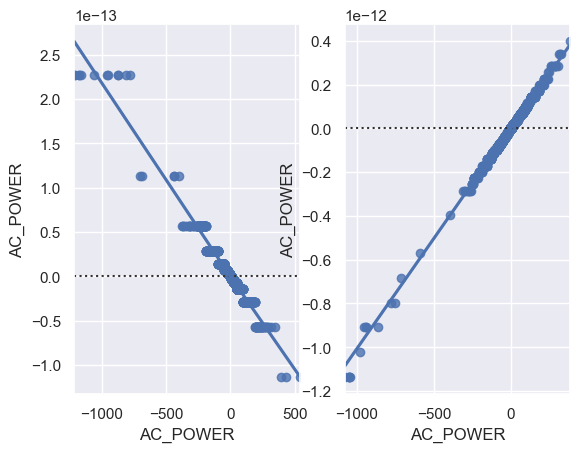

<Figure size 600x600 with 0 Axes>

In [51]:
# Plotting 

import seaborn as sns 
import matplotlib.pyplot as plt

residuals = y_dev - preds
residualsGB = y_dev - predsGB

plt.show()

fig , axes = plt.subplots(nrows=1, ncols=2)
sns.set_theme()
plt.figure(figsize=(6,6))
sns.residplot(x=residuals, y=residuals, lowess=True, ax=axes[0])
# plt.xlabel("Fitted Values")
# plt.ylabel("Residuals")
# plt.title("Residuals Plot Linear")
# sns.set_theme()
# plt.figure(figsize=(6,6))
sns.residplot(x=residualsGB, y=residualsGB, lowess=True, ax=axes[1])
# plt.xlabel("Fitted Values")
# plt.ylabel("Residuals")
# plt.title("Residuals Plot GB")